# Wall Street Bets Subreddit Sentiment Analysis

# Team 18

Nghia Bui,
Carmen Luisa So,
Parth Patel, and
Andrea Riccardi


In [2]:
from pmaw import PushshiftAPI # obsolete until further update #currently being updated  - expected to be working by next week
import datetime as dt
import pandas as pd
import time
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
import requests 
import yfinance as yf #pip install yfinance

# Reddit Scraper 

In [ ]:
api = PushshiftAPI()
ts_before = int(dt.datetime(2022,9,30).timestamp()) # converting 9.30.2022 to epoch format to create a timestamp
ts_after = int(dt.datetime(2021,9,30).timestamp()) # converting 9.30.2021 to epoch format to create a timestamp
sub = 'wallstreetbets'

In [18]:
companies = ['aapl','msft','goog','amzn','tsla','meta','nvda','pep','amd','nflx']

In [ ]:
# gather raw data
 # a list with the company tickers
for company in companies:
    query = api.search_submissions(title=company,size=1000,subreddit=sub,before=ts_before,after=ts_after,is_video=False)
    output = pd.DataFrame(query)
    output.to_csv(f'Assignment/Project/data/{company}.csv', encoding='utf-8', index=False)
    time.sleep(2)
    





In [ ]:
# some cleaning
for company in companies:#uses files created by the above for loop
    df = pd.read_csv(fr'Assignment\Project\data\raw\{company}.csv')
    # df = df[df['link_flair_text']=='DD']
    df.dropna(inplace=True, subset =['selftext']) # remove rows with no selftext
    if '[removed]' in df['selftext'].values:
        df.drop(df[df['selftext']=='[removed]'].index, inplace=True) # if a post has been removed by the moderator, delete it from the dataframe
    if '[deleted]' in df['selftext'].values:
        df.drop(df[df['selftext']=='[deleted]'].index, inplace=True) # if a post has been deleted by the moderator, delete if from the dataframe
    df = df[['title','selftext','retrieved_on']] # limit down the number of relevant columns
    df.to_csv(f'Assignment\Project\data\{company}_refinedwithdates.csv',encoding='utf-8',index=False)





In [ ]:
# generating monthly data
## creating monthly timestamp
month_start = [int(dt.datetime(2021,9,30).timestamp()),int(dt.datetime(2021,11,1).timestamp()),int(dt.datetime(2021,12,1).timestamp()),int(dt.datetime(2022,1,1).timestamp()),int(dt.datetime(2022,2,1).timestamp()),int(dt.datetime(2022,3,1).timestamp()),int(dt.datetime(2022,4,1).timestamp()),int(dt.datetime(2022,5,1).timestamp()),int(dt.datetime(2022,6,1).timestamp()),int(dt.datetime(2022,7,1).timestamp()),int(dt.datetime(2022,8,1).timestamp()),int(dt.datetime(2022,9,1).timestamp()),]
month_end = [int(dt.datetime(2021,10,31).timestamp()),int(dt.datetime(2021,11,30).timestamp()),int(dt.datetime(2021,12,31).timestamp()),int(dt.datetime(2022,1,31).timestamp()),int(dt.datetime(2022,2,28).timestamp()),int(dt.datetime(2022,3,31).timestamp()),int(dt.datetime(2022,4,30).timestamp()),int(dt.datetime(2022,5,31).timestamp()),int(dt.datetime(2022,6,30).timestamp()),int(dt.datetime(2022,7,31).timestamp()),int(dt.datetime(2022,8,31).timestamp()),int(dt.datetime(2022,9,30).timestamp())]

monthly = dict() # create an empty dictionary to store reddit posts by months
for company in companies:
    monthly[company] = list()

for company in companies: #uses files created by the previous chunk of code
    data = pd.read_csv(fr'E:\Download\Miu\Fordham\Web Analytics\Assignment\Project\data\refined with dates\{company}_refinedwithdates.csv')
    for z in range(len(month_end)): # to create 12 df for 12 months
        df = data.loc[(data['retrieved_on']<=month_end[z]) & (data['retrieved_on']>=month_start[z])] # slicing the df to separate months
        monthly[company].append(df) # append the df to the corresponding keys (company tickers)

In [ ]:
sid = SentimentIntensityAnalyzer()
for company in companies:
    sentiment_score = {'sentiment': list()}
    for i in range(len(monthly['aapl'])):
        month = monthly[company][i].copy() 
        month['Complete_Text'] = month['title'] + month['selftext'] # merging the title and selftext
        month['Sentiment'] = np.nan # create a new sentiment column with no values
        month.reset_index(inplace=True,drop=True) # reset index so that they are in consecutive integer values
        for i in month.index:
            month.at[i,'Complete_Text'] = re.sub(r'.http\S+', '', month.iloc[i]['Complete_Text']) # remove all the links included in the reddit posts
            sentiment = sid.polarity_scores(month.iloc[i]['Complete_Text'])
            month.at[i,'Sentiment'] = sentiment['compound'] # assign values to sentiment column
        sentiment_score['sentiment'].append(month['Sentiment'].mean()) # calculate the average sentiment score for the month
    company_monthly = pd.DataFrame(sentiment_score) # put it into df to export to csv for easier collaborations
    company_monthly.to_csv(fr'E:\Download\Miu\Fordham\Web Analytics\Assignment\Project\data\monthly\{company}_monthly.csv')

# Yahoo finance Scraper

In [5]:
my_headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'}

In [6]:
Stocks = ['AAPL', 'MSFT','GOOG', 'AMZN', 'META', 'TSLA', 'NVDA', 'PEP', 'NFLX', 'AMD']

In [7]:
def get_stats(ticker):# will get ticker ratios #returns a data frame
    page = 'https://finance.yahoo.com/quote/'+ str(ticker)+'/key-statistics?p=' + str(ticker)
    response = requests.get(page, headers = my_headers) #getting the page
    stats_data = pd.read_html(response.text)
    stats_df = stats_data[0] 
    stats_df.drop(columns=stats_df.columns[1], axis=1, inplace=True)
    stats_df['Ratios'] = stats_df['Unnamed: 0'] 
    stats_df.drop(columns=stats_df.columns[0], axis=1, inplace=True)#getting rid of 'Unnamed: 0' column
    stats_df.set_index('Ratios', inplace = True)#setting ratios as the index
    stats_df.drop('Market Cap (intraday)', axis=0,inplace=True)#droping two rows as they are not required
    stats_df.drop('Enterprise Value',axis=0,inplace=True)
    stats_df = stats_df.transpose()
    return stats_df


In [8]:
def get_hist(ticker):#using yfinance api getting historical prices #returns a data frmae
    str_ticker = yf.Ticker(str(ticker))
    #we can search for various periods. eg: '1d', '5d', '6mo' , '1y', '5y', 'max'
    hist_data = str_ticker.history(start='2021-09-28',end='2022-10-01',ignore_tz = True)
    hist_data['Daily Return %'] = ((np.log(hist_data['Close'].div(hist_data['Close'].shift(1))))*100)#calculating daily return
    hist_data.drop('Dividends', axis=1, inplace=True) #dropping multiple columns as they are not required
    hist_data.drop('Stock Splits', axis=1, inplace=True)
    hist_data.drop('Open', axis=1, inplace=True)
    hist_data.drop('High', axis=1, inplace=True)
    hist_data.drop('Low', axis=1, inplace=True)
    hist_data.drop('Volume', axis=1, inplace=True)
    hist_data = hist_data.dropna(axis=0)
    return hist_data


In [9]:
monthly_dates = ['09/30/2021', #all monthly Dates in each qtr for the time frame
'10/29/2021',
'11/30/2021',
'12/31/2021',
'01/31/2022',
'02/28/2022',
'03/31/2022',
'04/29/2022',
'05/31/2022',
'06/30/2022',
'07/29/2022',
'08/31/2022',
'09/30/2022'
        ]
def monthly_hist(ticker): #this function gets the monthly stock return and returns a data frame
    tic_data = get_hist(ticker=ticker)
    tic_dict = {}
    for date in monthly_dates:
        tic_dict[date]= tic_data.loc[str(date)]['Close'] #saving to dict with date as the key and the close price as value
    tic_df = pd.DataFrame([tic_dict])

    tic_df = tic_df.transpose()
    tic_df['Close Price'] = tic_df[0] #creating a new column whose data is equal to column '0'
    tic_df.drop(columns=tic_df.columns[0], axis=1, inplace=True)#droping colum '0' 
    tic_df['Monthly Returns %'] = ((np.log(tic_df['Close Price'].div(tic_df['Close Price'].shift(1))))*100)
    #current month return = natural log e(close price current month/close price previous month) 
    return tic_df

In [10]:
def combine_data(ticker): #this will combine the ratios and returns a dat Frame
    x = get_stats(ticker) 
    y = monthly_hist(ticker)
    y = y.dropna() #droping the '2021-09-30' as it is no longer required 
    q_1 = [x.iloc[4]]*3 #locating the first row and repeating it 3 times as we have 3 months in each qtr. returns a list 
    q1_df = pd.DataFrame(q_1) #converting the list above into data frame
    q_2 = [x.iloc[3]]*3
    q2_df = pd.DataFrame(q_2)
    q_3 = [x.iloc[2]]*3
    q3_df = pd.DataFrame(q_3)
    q_4 = [x.iloc[1]]*3
    q4_df = pd.DataFrame(q_4)
    year_df = pd.DataFrame()
    year_df = pd.concat([q1_df,q2_df,q3_df,q4_df]) #merging all qtr data 
    year_df = year_df.set_index(y.index) #setting the index of combined df to the months of each qtr 
    year_df = pd.concat([y,year_df],axis=1) # combining the ratios and the (closing price + return) data frame
    year_df.drop('Close Price',axis=1,inplace=True)
    return year_df


In [ ]:
for stock in Stocks:
    stocks_data = combine_data(stock) #calling combine_data and svaing to variable 
    stocks_data.to_csv(stock+'_combined.csv',encoding='utf-8') #writing stock data to csv. eg: AAPL_combined.csv in the pwd

# MLR Model

In [27]:
companies = ['aapl','msft','goog','amzn','tsla','meta','nvda','pep','amd','nflx'] 

Links to download files for the MLR
Ratios = https://drive.google.com/drive/folders/1go_3XDSDgZQ4XV94pFSAbcCv__-BgflY?usp=share_link 
, Senti = https://drive.google.com/drive/folders/18Iye6yVEVJWGS__RNKD2E9-UtGzyyRKP?usp=share_link

In [25]:
def mlr_returns(company):
    ratios = pd.read_csv(fr'C:/Users/parth/Desktop/WA project/Historical/{company.upper()}_combined.csv', index_col=0) #change to file path after downloading files using the ratio link above
    senti = pd.read_csv(fr'C:/Users/parth/Desktop/WA project/Sentiment files/{company}_monthly.csv', index_col=0).set_index(ratios.index)#change to file path after downloading files using the senti link above
    senti.fillna(0,inplace=True) # because some stocks are not discussed as much as the others, there are months with no posts mentioning about that stock => fill months with missing value with neutral sentiment
    combined = pd.concat([ratios,senti],axis=1) # merge the df with financial ratios and df with sentiments base on index (they have the same number of rows)
    variables = list(combined.columns) # columns that contain independent variables
    variables.remove('Monthly Returns %') # this is dependent variable => remove it from the list of indenpendent variables
    X = combined[variables] # declaring independent variables
    y = combined['Monthly Returns %'] # declaring dependent variables
    regr = linear_model.LinearRegression()
    regr.fit(X,y)
    coef_table = pd.DataFrame([dict(zip(variables,regr.coef_))],index=['coefficients']) # make a table to display the coefs of the independent variable
    pred_values = regr.predict(X)
    combined = combined.assign(Prediction=pred_values) # create and assign predicted values to the existing table
    pred = list(combined['Prediction']) # turn values into lists to plot graph
    true = list(combined['Monthly Returns %']) # turn values into lists to plot graph
    x_axis = ['Oct 21','Nov 21','Dec 21','Jan 22','Feb 22','Mar 22','Apr 22','May 22','Jun 22','Jul 22','Aug 22','Sep 22']
    plt.plot(x_axis,pred,label='Predicted monthly returns')
    plt.plot(x_axis,true,label='Actual monthly returns')
    plt.legend()
    plt.title(f'{company.upper()} Predicted vs Actual')
    print(f'{company.upper()}\'s returns model R-Square:',metrics.r2_score(true,pred))
    return(print(coef_table),plt.show())



In [24]:
def mlr_sentiment_score(company): #this function will run an MLR with sentiment as the dependent variable

    ratios = pd.read_csv(fr'C:/Users/parth/Desktop/WA project/Historical/{company.upper()}_combined.csv', index_col=0)
    senti = pd.read_csv(fr'C:/Users/parth/Desktop/WA project/Sentiment files/{company}_monthly.csv', index_col=0).set_index(ratios.index)
    senti.fillna(0,inplace=True)
    combined = pd.concat([ratios,senti],axis=1)
    variables = list(combined.columns)
    variables.remove('sentiment')
    X = combined[variables]
    y = combined['sentiment']
    regr = linear_model.LinearRegression()
    regr.fit(X,y)
    coef_table = pd.DataFrame([dict(zip(variables,regr.coef_))],index=['coefficients'])
    pred_values = regr.predict(X)
    combined = combined.assign(Prediction=pred_values)
    pred = list(combined['Prediction'])
    true = list(combined['sentiment'])
    x_axis = ['Oct 21','Nov 21','Dec 21','Jan 22','Feb 22','Mar 22','Apr 22','May 22','Jun 22','Jul 22','Aug 22','Sep 22']
    plt.plot(x_axis,pred,label='Predicted sentiment scores')
    plt.plot(x_axis,true,label='Actual sentiment scores')
    plt.legend()
    plt.title(f'{company.upper()} Predicted vs Actual')
    print(f'{company.upper()}\'s sentiment score model R-Square:',metrics.r2_score(true,pred))
    return(print(coef_table),plt.show())

AAPL's returns model R-Square: 0.40238281677358534
              Trailing P/E   Forward P/E  PEG Ratio (5 yr expected)  \
coefficients -8.163788e+11 -1.226062e+12              -1.356535e+11   

              Price/Sales (ttm)  Price/Book (mrq)  Enterprise Value/Revenue  \
coefficients       4.850303e+10      2.139960e+12              5.354123e+10   

              Enterprise Value/EBITDA  sentiment  
coefficients             4.337362e+11   3.819529  


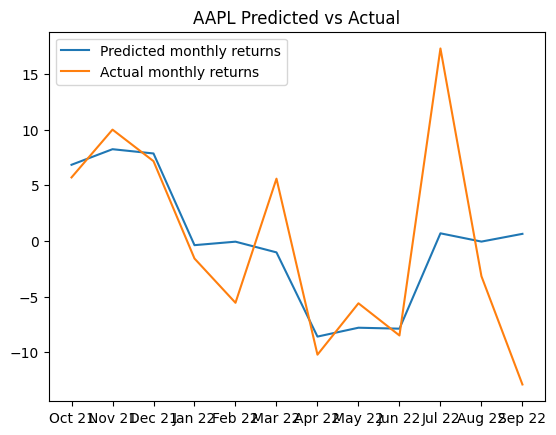

AAPL's sentiment score model R-Square: 0.5688820886158886
              Monthly Returns %  Trailing P/E   Forward P/E  \
coefficients           0.001063 -2.134399e+11 -2.899086e+11   

              PEG Ratio (5 yr expected)  Price/Sales (ttm)  Price/Book (mrq)  \
coefficients              -3.042066e+10       1.635141e+10      5.323631e+11   

              Enterprise Value/Revenue  Enterprise Value/EBITDA  
coefficients             -1.276393e+10             1.163229e+11  


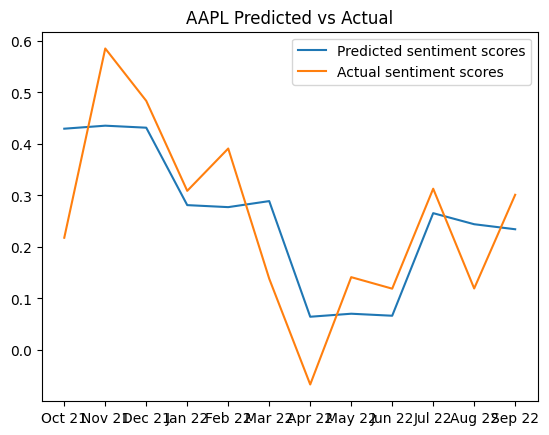

MSFT's returns model R-Square: 0.43608885737234426
              Trailing P/E   Forward P/E  PEG Ratio (5 yr expected)  \
coefficients  1.486650e+12  6.496398e+12               1.875923e+11   

              Price/Sales (ttm)  Price/Book (mrq)  Enterprise Value/Revenue  \
coefficients      -1.791533e+13     -1.507282e+13              1.697353e+12   

              Enterprise Value/EBITDA  sentiment  
coefficients             1.778856e+12   7.878697  


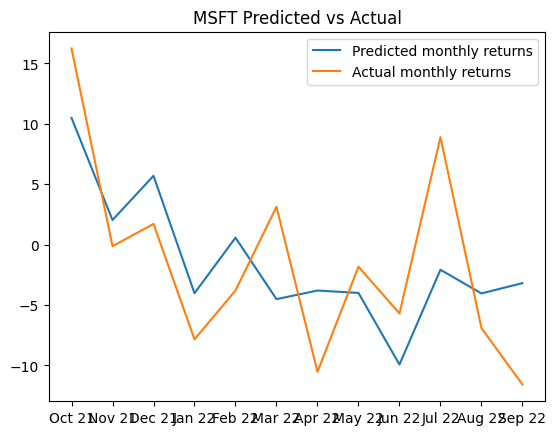

MSFT's sentiment score model R-Square: 0.29134865397672394
              Monthly Returns %  Trailing P/E   Forward P/E  \
coefficients           0.020185  5.274095e+09 -1.932409e+11   

              PEG Ratio (5 yr expected)  Price/Sales (ttm)  Price/Book (mrq)  \
coefficients              -1.646264e+10       4.814096e+11      4.060109e+11   

              Enterprise Value/Revenue  Enterprise Value/EBITDA  
coefficients             -7.573894e+10            -4.175703e+10  


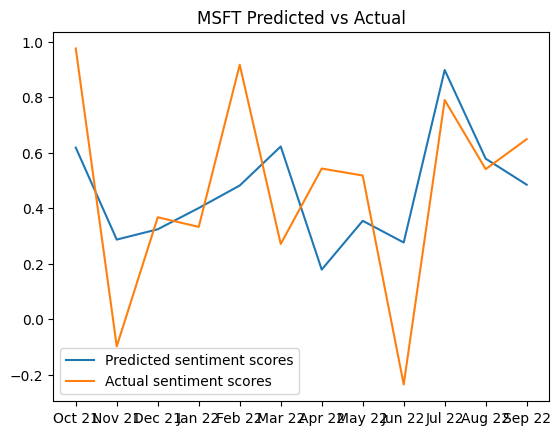

GOOG's returns model R-Square: 0.2601687558316309
              Trailing P/E  Forward P/E  PEG Ratio (5 yr expected)  \
coefficients      0.558752    -0.276419                  -0.058724   

              Price/Sales (ttm)  Price/Book (mrq)  Enterprise Value/Revenue  \
coefficients          -0.030681         -0.295234                   1.17894   

              Enterprise Value/EBITDA  sentiment  
coefficients                -0.678259   0.323306  


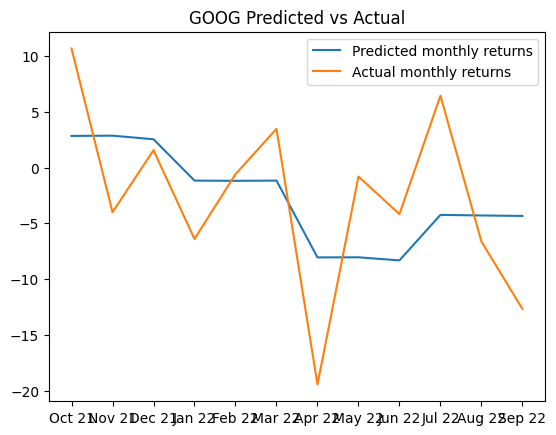

GOOG's sentiment score model R-Square: 0.42360227596868316
              Monthly Returns %  Trailing P/E  Forward P/E  \
coefficients           0.000678      0.020101      -0.1609   

              PEG Ratio (5 yr expected)  Price/Sales (ttm)  Price/Book (mrq)  \
coefficients                  -0.014013          -0.051229         -0.111454   

              Enterprise Value/Revenue  Enterprise Value/EBITDA  
coefficients                  0.303017                -0.041064  


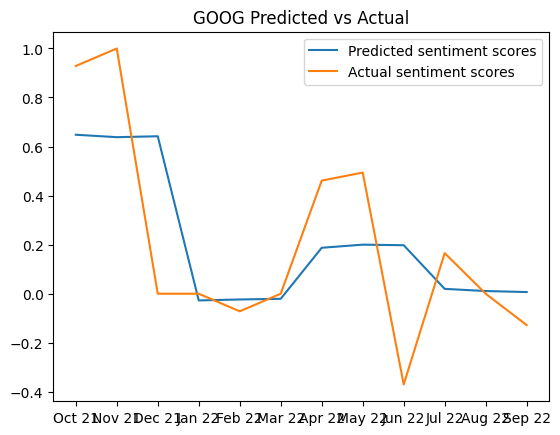

AMZN's returns model R-Square: 0.2979269519779527
              Trailing P/E  Forward P/E  PEG Ratio (5 yr expected)  \
coefficients      -0.62281    -0.059504                    0.01714   

              Price/Sales (ttm)  Price/Book (mrq)  Enterprise Value/Revenue  \
coefficients          -0.039681         -0.132044                  0.003589   

              Enterprise Value/EBITDA  sentiment  
coefficients                -0.067006  -2.379891  


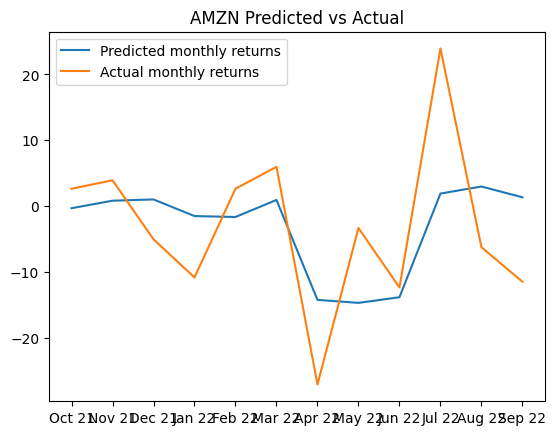

AMZN's sentiment score model R-Square: 0.09198639864545743
              Monthly Returns %  Trailing P/E  Forward P/E  \
coefficients          -0.002412     -0.024273    -0.005428   

              PEG Ratio (5 yr expected)  Price/Sales (ttm)  Price/Book (mrq)  \
coefficients                    0.00027           -0.00134         -0.004251   

              Enterprise Value/Revenue  Enterprise Value/EBITDA  
coefficients                  0.001172                -0.000476  


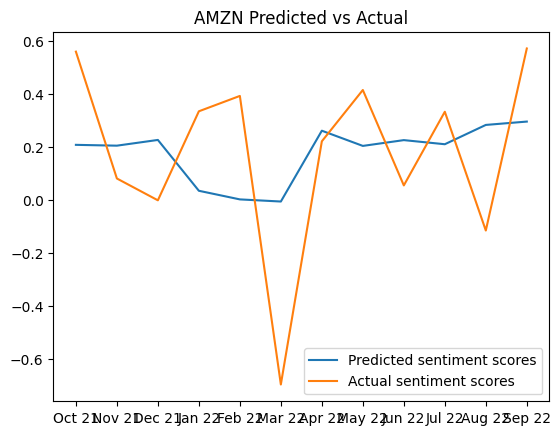

TSLA's returns model R-Square: 0.5412870653407145
              Trailing P/E  Forward P/E  PEG Ratio (5 yr expected)  \
coefficients      0.018881    -0.263981                   -0.01284   

              Price/Sales (ttm)  Price/Book (mrq)  Enterprise Value/Revenue  \
coefficients          -0.058262          -0.10485                 -0.114326   

              Enterprise Value/EBITDA  sentiment  
coefficients                 0.031453  76.613576  


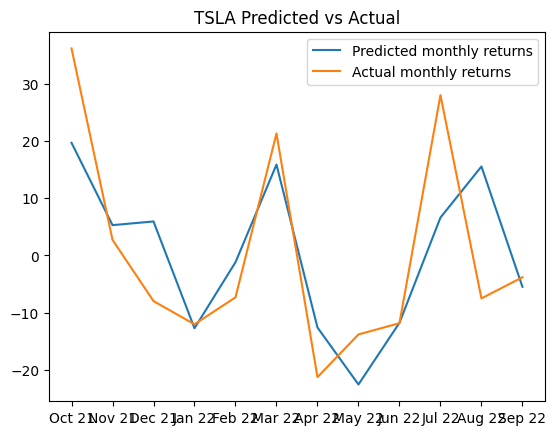

TSLA's sentiment score model R-Square: 0.6366520361205152
              Monthly Returns %  Trailing P/E  Forward P/E  \
coefficients           0.004348      0.000179    -0.002092   

              PEG Ratio (5 yr expected)  Price/Sales (ttm)  Price/Book (mrq)  \
coefficients                  -0.000147           -0.00044           -0.0008   

              Enterprise Value/Revenue  Enterprise Value/EBITDA  
coefficients                 -0.001084                 0.002544  


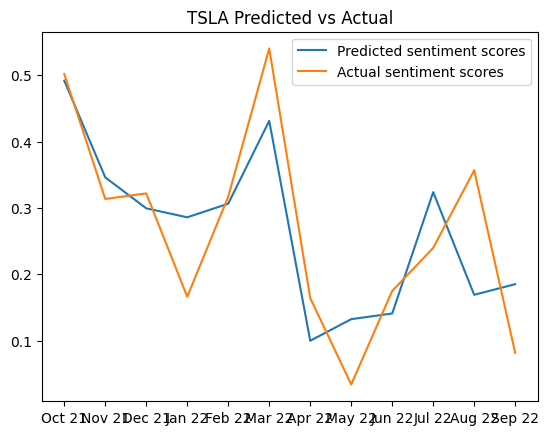

META's returns model R-Square: 0.49348133430234176
              Trailing P/E   Forward P/E  PEG Ratio (5 yr expected)  \
coefficients  5.559728e+12 -7.549611e+11              -2.390782e+12   

              Price/Sales (ttm)  Price/Book (mrq)  Enterprise Value/Revenue  \
coefficients      -1.308447e+12     -1.493010e+12             -9.955813e+12   

              Enterprise Value/EBITDA  sentiment  
coefficients             3.460104e+12  30.532914  


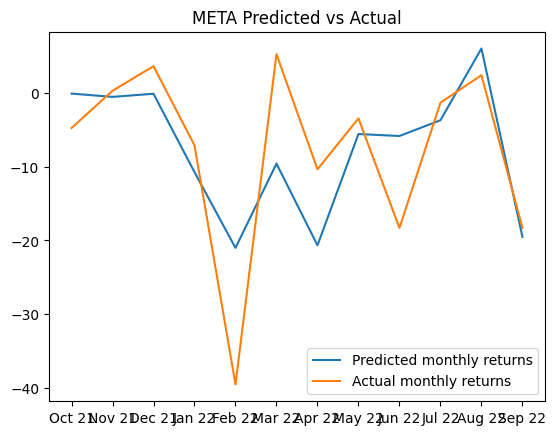

META's sentiment score model R-Square: 0.6058247685064049
              Monthly Returns %  Trailing P/E   Forward P/E  \
coefficients           0.012586  1.195871e+11 -1.694768e+10   

              PEG Ratio (5 yr expected)  Price/Sales (ttm)  Price/Book (mrq)  \
coefficients              -5.647508e+10      -1.543883e+10     -2.788710e+10   

              Enterprise Value/Revenue  Enterprise Value/EBITDA  
coefficients             -2.282683e+11             7.924014e+10  


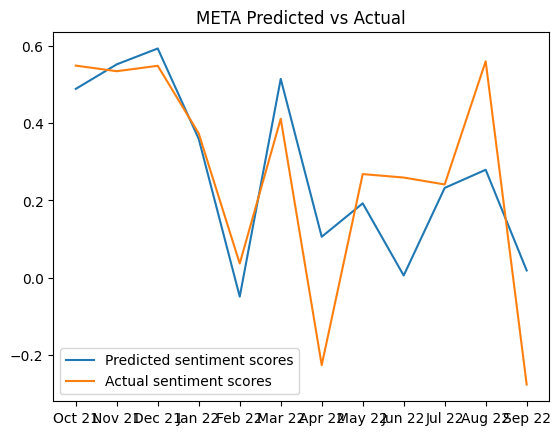

NVDA's returns model R-Square: 0.3519596368852389
              Trailing P/E  Forward P/E  PEG Ratio (5 yr expected)  \
coefficients      1.025144     0.234631                    0.29465   

              Price/Sales (ttm)  Price/Book (mrq)  Enterprise Value/Revenue  \
coefficients           0.162482          0.216959                 -0.610946   

              Enterprise Value/EBITDA  sentiment  
coefficients                 0.069346  -7.089265  


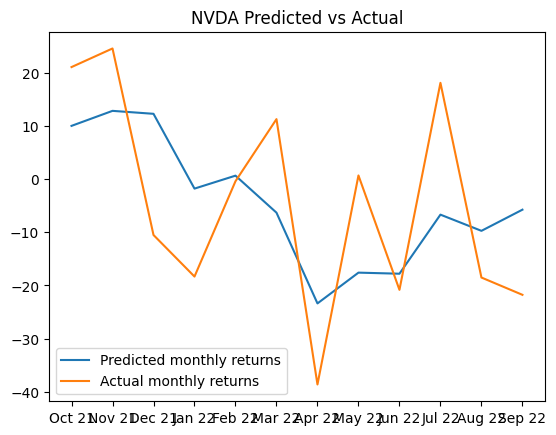

NVDA's sentiment score model R-Square: 0.20398780040071707
              Monthly Returns %  Trailing P/E  Forward P/E  \
coefficients          -0.002856      0.023502     0.003949   

              PEG Ratio (5 yr expected)  Price/Sales (ttm)  Price/Book (mrq)  \
coefficients                   0.008091           0.003099          0.004534   

              Enterprise Value/Revenue  Enterprise Value/EBITDA  
coefficients                 -0.021261                 0.001235  


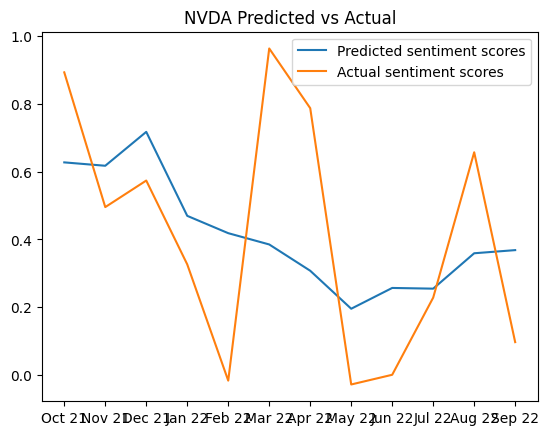

PEP's returns model R-Square: 0.4551168430971426
              Trailing P/E   Forward P/E  PEG Ratio (5 yr expected)  \
coefficients -5.583534e+11  1.958870e+11              -1.634925e+10   

              Price/Sales (ttm)  Price/Book (mrq)  Enterprise Value/Revenue  \
coefficients      -1.807271e+10      1.289948e+12              1.592565e+11   

              Enterprise Value/EBITDA  sentiment  
coefficients            -2.944553e+10   6.881883  


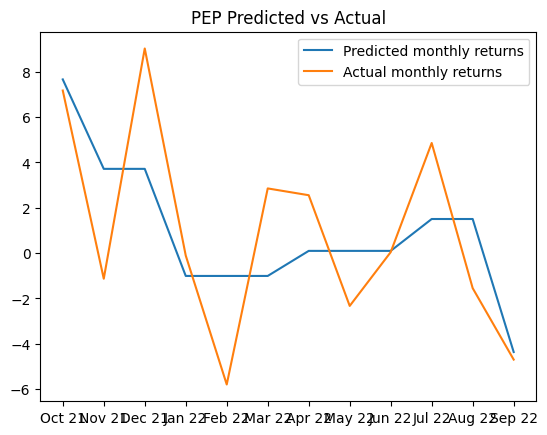

PEP's sentiment score model R-Square: 0.4720644268805272
              Monthly Returns %  Trailing P/E   Forward P/E  \
coefficients           0.030946  2.323773e+10 -9.404451e+09   

              PEG Ratio (5 yr expected)  Price/Sales (ttm)  Price/Book (mrq)  \
coefficients               4.155337e+08       5.838029e+08     -5.058064e+10   

              Enterprise Value/Revenue  Enterprise Value/EBITDA  
coefficients             -5.686793e+09             1.407529e+09  


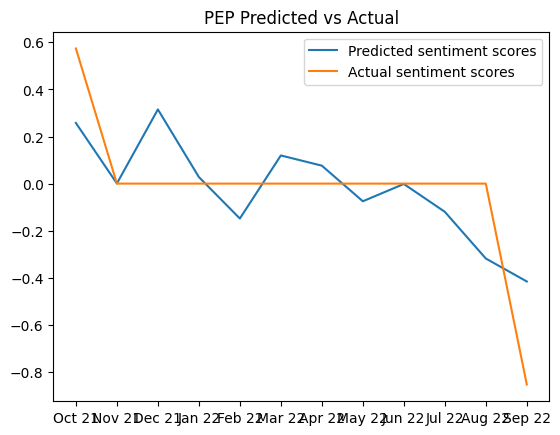

AMD's returns model R-Square: 0.26284462215831383
              Trailing P/E   Forward P/E  PEG Ratio (5 yr expected)  \
coefficients  2.823084e+13  3.933028e+12               4.873832e+12   

              Price/Sales (ttm)  Price/Book (mrq)  Enterprise Value/Revenue  \
coefficients      -2.051624e+13     -3.315674e+13             -5.229554e+13   

              Enterprise Value/EBITDA  sentiment  
coefficients             2.112753e+13   34.44013  


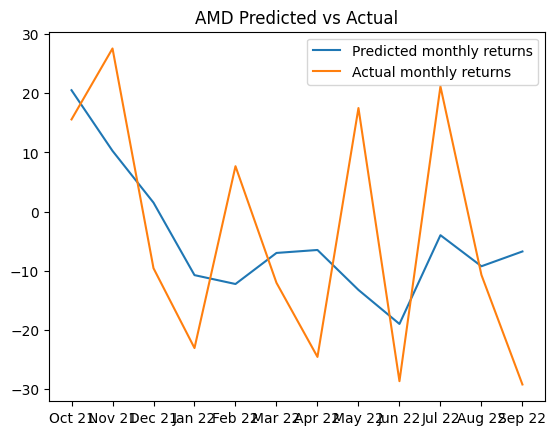

AMD's sentiment score model R-Square: 0.33887851135131386
              Monthly Returns %  Trailing P/E   Forward P/E  \
coefficients           0.002187 -4.624642e+11 -6.029523e+10   

              PEG Ratio (5 yr expected)  Price/Sales (ttm)  Price/Book (mrq)  \
coefficients              -9.424898e+10       3.424970e+11      5.572710e+11   

              Enterprise Value/Revenue  Enterprise Value/EBITDA  
coefficients              8.579918e+11            -3.543621e+11  


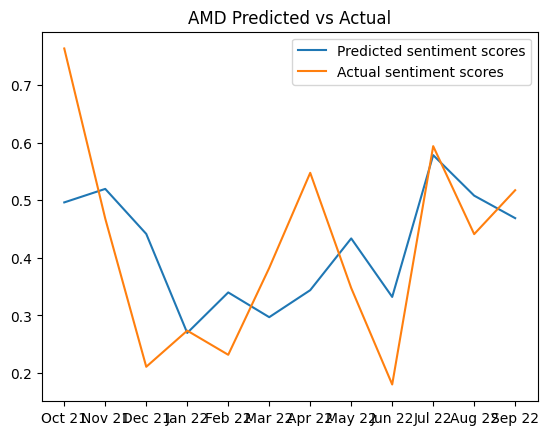

NFLX's returns model R-Square: 0.5114463412969065
              Trailing P/E  Forward P/E  PEG Ratio (5 yr expected)  \
coefficients      5.533463    -4.929515                   0.189189   

              Price/Sales (ttm)  Price/Book (mrq)  Enterprise Value/Revenue  \
coefficients           0.048354          0.878898                 -0.391091   

              Enterprise Value/EBITDA  sentiment  
coefficients                -2.233529 -54.005351  


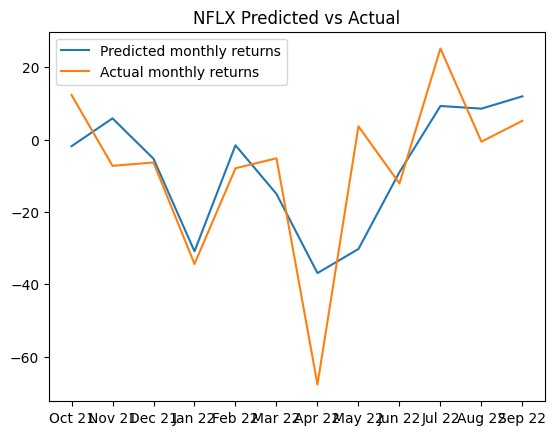

NFLX's sentiment score model R-Square: 0.8076171453635544
              Monthly Returns %  Trailing P/E  Forward P/E  \
coefficients          -0.004356      0.068504    -0.024367   

              PEG Ratio (5 yr expected)  Price/Sales (ttm)  Price/Book (mrq)  \
coefficients                    0.00111           0.000908          0.012602   

              Enterprise Value/Revenue  Enterprise Value/EBITDA  
coefficients                 -0.000892                -0.052146  


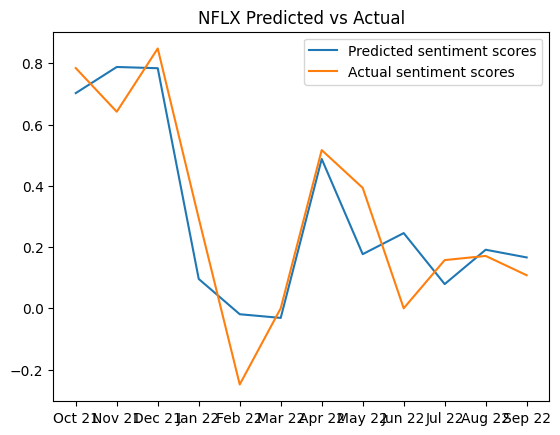

In [26]:
for company in companies:
    mlr_returns(company)
    mlr_sentiment_score(company)